In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import random

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# Visualizations will be shown in the notebook.
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

image_file = 'test_images/test6.jpg'

window_width = 64 #64 
window_height = 120 #120 180 con el primer src, 120
margin = 40 #40 con el primersrc, 60

"""
src = np.float32(
    [[0, 720],
    [1280, 720],
    [510, 480],
    [770, 480]])

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])
"""


src = np.float32(
    [[0, 720],
    [1280, 720],
    [510, 480],
    [770, 480]])

dst = np.float32(
    [[0, 720],
    [1280, 720],
    [0, 0],
    [1280, 0]])


m = cv2.getPerspectiveTransform(src, dst)
m_inv = cv2.getPerspectiveTransform(dst, src)

with open('calibration_data/calibration_matrices.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
print(mtx)
print()
print(dist)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def abs_sobel_thres(img, orient='x', sobel_thresh=(20, 100)):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thres(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thres(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    """
    Return the direction of the gradient
    for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

def HLS_thres(img, HLS_thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > HLS_thresh[0]) & (s_channel <= HLS_thresh[1])] = 1
    return binary_output

def HSV_thres(img, HSV_thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    s_channel = hsv[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > HSV_thresh[0]) & (s_channel <= HSV_thresh[1])] = 1
    return binary_output

def yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([0,100,100])
    upper_yellow = np.array([50,255,255])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    return mask

def white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = np.array([10,0,170])
    upper_white = np.array([255,80,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    return mask    

'''
def combined_thresh(img):
    abs_bin = abs_sobel_thres(img, orient='x', sobel_thresh=(30, 255))
    mag_bin = mag_thres(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_thres(img, sobel_kernel=15, dir_thresh=(0.7, 1.1))
    hls_bin = HLS_thres(img, HLS_thresh=(150, 255))#80
    hsv_bin = HSV_thres(img, HSV_thresh=(150, 255))#80
    yellow_mask = yellow(img)
    white_mask = white(img)
    combined = np.zeros_like(dir_bin)
    #combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1)) | ((yellow == 1)&(white == 1))] = 1
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((yellow == 1)&(white == 1))] = 1

    return combined
'''
#50,60,0.7,190

def combined_thresh(img):
    abs_bin = abs_sobel_thres(img, orient='x', sobel_thresh=(60, 255))
    mag_bin = mag_thres(img, sobel_kernel=3, mag_thresh=(60, 255))
    dir_bin = dir_thres(img, sobel_kernel=15, dir_thresh=(0.7, 1.1))
    hls_bin = HLS_thres(img, HLS_thresh=(12, 255))
    hsv_bin = HSV_thres(img, HSV_thresh=(170, 255))
    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1 | ((mag_bin == 1) & (dir_bin == 1))) | ((hls_bin == 1)&(hsv_bin == 1))] = 1
    #combined[((hls_bin == 1)&(hsv_bin == 1))] = 1

    return combined

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

[[-0.24688507 -0.02373156 -0.00109831  0.00035107 -0.00259866]]


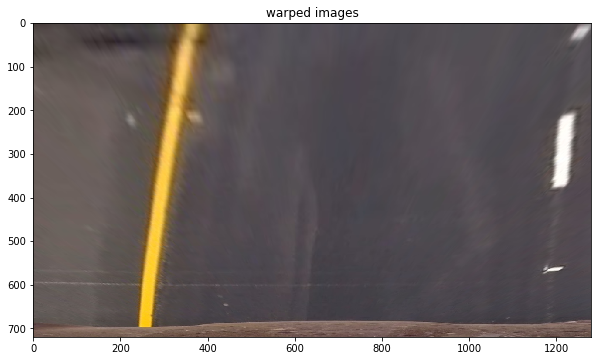

In [2]:
image = cv2.imread(image_file)
image = cv2.resize(image, (1280, 720)) 
imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.undistort(image, mtx, dist, None, mtx)
imshape = image.shape
warped_img = cv2.warpPerspective(imagergb, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
#warped_img[:,0:150] = 0
#warped_img[300:720,500:1000] = 0
#the_vertices = vertices = np.array([[(200,imshape[0]),(200, 0), (imshape[1],0), (imshape[1],imshape[0]), (imshape[1]-200,imshape[0]), (imshape[1]-200,imshape[0]-400), (400,imshape[0]-400), (400,imshape[0])]], dtype=np.int32)
#image_region = region_of_interest(warped_img, the_vertices)
plt.imshow(warped_img, cmap="gray")
#plt.imshow(image_region, cmap="gray")
plt.title('warped images')

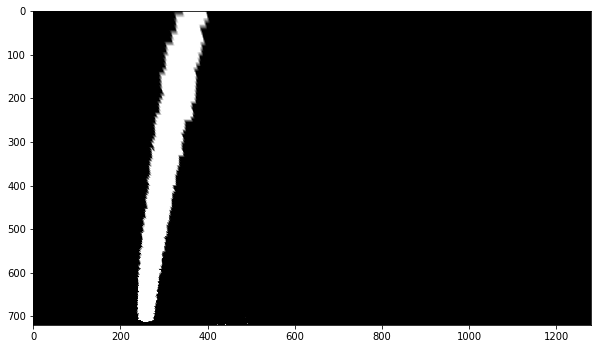

In [3]:
yellow_mask = yellow(image)
warped_y = cv2.warpPerspective(yellow_mask, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped_y, cmap="gray")

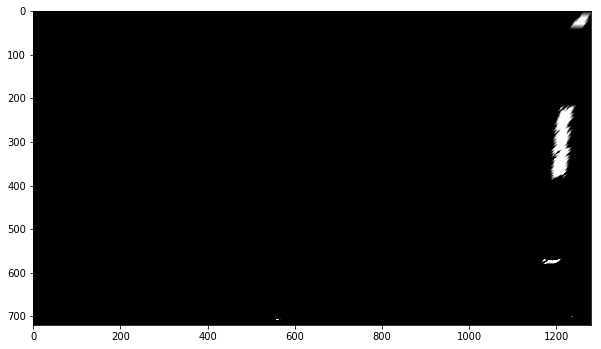

In [4]:
def white(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_white = np.array([10,0,170])
    upper_white = np.array([255,80,255])
    mask = cv2.inRange(hsv, lower_white, upper_white)
    return mask    

white_mask = white(image)
warped_w = cv2.warpPerspective(white_mask, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped_w, cmap="gray")

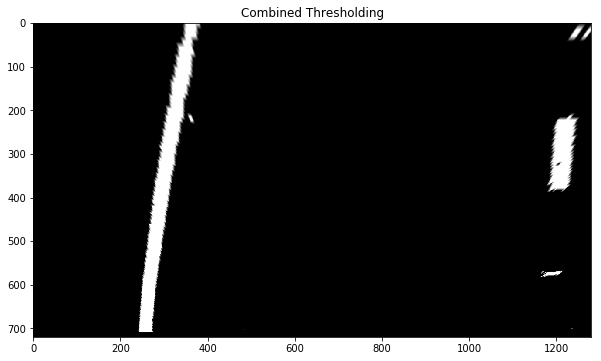

In [5]:
binary = combined_thresh(image)
warped = cv2.warpPerspective(binary, m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
warped[:,0:150] = 0
warped[300:720,500:1000] = 0
#warped = cv2.dilate(warped,np.ones((7, 7)))
#warped = cv2.erode(warped,np.ones((7, 7)))
plt.imshow(warped, cmap="gray")
plt.title('Combined Thresholding')

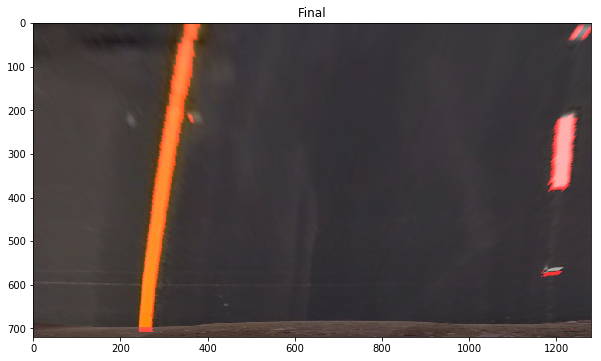

In [6]:
warped_bin = warped*255
new_binary = np.zeros((warped_bin.shape[0],warped_bin.shape[1],3), dtype=np.uint8)
for y in range(0,warped_bin.shape[1]-1):
    for x in range(0,warped_bin.shape[0]-1):
        new_binary[x][y][0] = warped_bin[x][y]
final = cv2.addWeighted(warped_img, 0.7, new_binary, 1.0, 0.0)
plt.imshow(final, cmap="gray")
plt.title('Final')

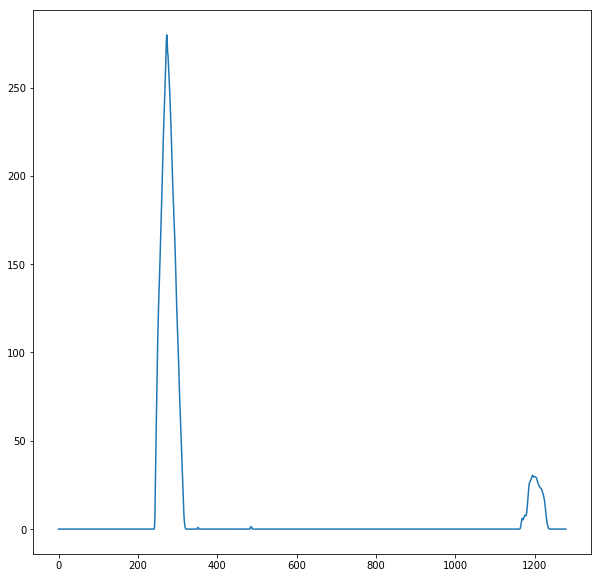

In [7]:
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

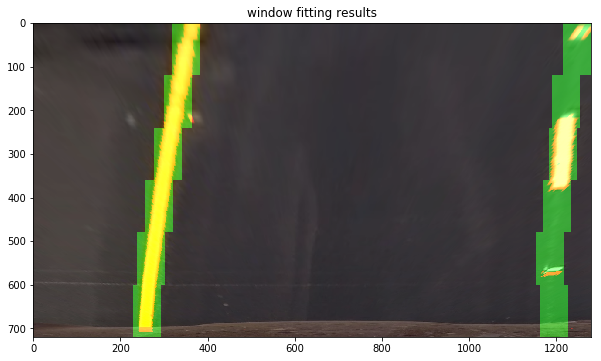

In [8]:
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
left_mask = np.concatenate((np.ones((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)*255, np.zeros((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)), axis=1)
right_mask = np.concatenate((np.zeros((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8), np.ones((warped.shape[0],int(warped.shape[1]/2),3), dtype=np.uint8)*255), axis=1)
left = cv2.bitwise_and(left_mask,output)
right = cv2.bitwise_and(right_mask,output)

final_output = cv2.addWeighted(final, 1.0, output, 0.9, 0.0)
    
# Display the final results
plt.imshow(final_output,cmap="gray")
plt.title('window fitting results')

In [9]:
left_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(left, cv2.COLOR_BGR2GRAY))))
right_points = np.transpose(np.asarray(np.nonzero(cv2.cvtColor(right, cv2.COLOR_BGR2GRAY))))

lout = np.polyfit(left_points[:,0],left_points[:,1],2)
rout = np.polyfit(right_points[:,0],right_points[:,1],2)

[253 719]


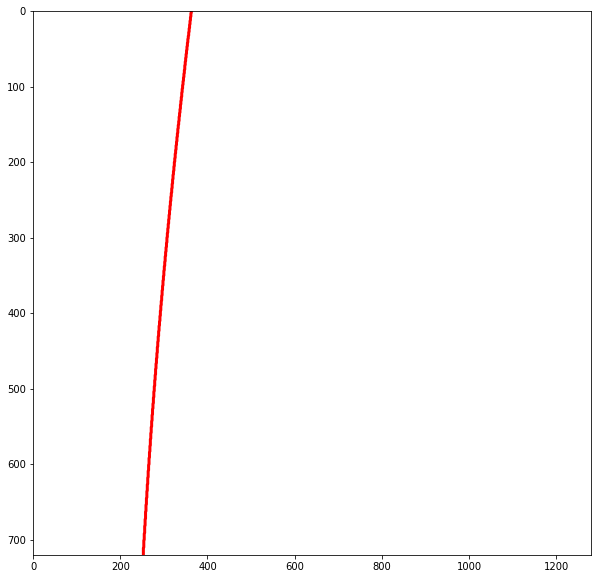

In [10]:
leftout_x = []
leftout_y = []
left_line_points = np.zeros((1,720,2), dtype=np.int32)
the_points = np.zeros((1,720*2,2), dtype=np.int32)


for i in range(0,720):
    #leftout_y.append(i)
    #leftout_x.append(int(lout[0]*i*i + lout[1]*i + lout[2]))
    leftout_y.append(i)
    leftout_x.append(int(lout[0]*i*i + 1*lout[1]*i + lout[2]))
    left_line_points[0][i] = [int(lout[0]*i*i + lout[1]*i + lout[2]),i]
    the_points[0][i] = [int(lout[0]*i*i + lout[1]*i + lout[2]),i]

print(the_points[0][719])
    
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(leftout_x, leftout_y, color='red', linewidth=3)
plt.gca().invert_yaxis()

[1190  719]
[1254    0]
937.0


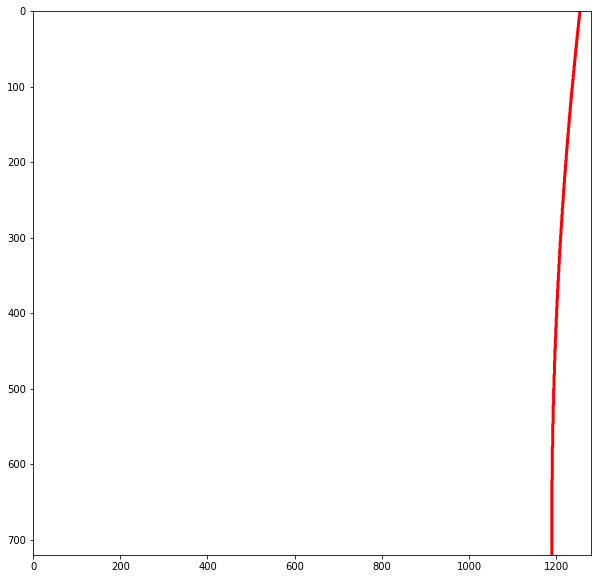

In [11]:
rightout_x = []
rightout_y = []
right_line_points = np.zeros((1,720,2), dtype=np.int32)

for i in range(0,720):
    #rightout_y.append(719-i)
    #rightout_x.append(int(rout[0]*(719-i)*(719-i) + rout[1]*(719-i) + rout[2]))
    rightout_y.append(719-i)
    rightout_x.append(int(rout[0]*(719-i)*(719-i) + rout[1]*(719-i) + rout[2]))
    right_line_points[0][i] = [int(rout[0]*(719-i)*(719-i) + rout[1]*(719-i) + rout[2]),(719-i)]
    the_points[0][i+720] = [int(rout[0]*(719-i)*(719-i) + rout[1]*(719-i) + rout[2]),(719-i)]
    #the_points[0][i+720] = [int(lout[0]*(719-i)*(719-i) + lout[1]*(719-i) + rout[2]),(719-i)]
    #the_points[0][i+720] = [int(lout[0]*(719-i)*(719-i) + lout[1]*(719-i) + (lout[2]+910)),(719-i)]

print(the_points[0][720])
print(the_points[0][720*2-1])
dist = np.linalg.norm(the_points[0][719]-the_points[0][720])
print(dist)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(rightout_x, rightout_y, color='red', linewidth=3)
plt.gca().invert_yaxis()

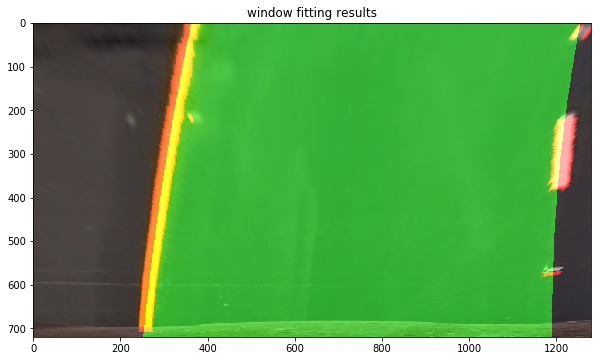

In [12]:
output_pol = np.zeros_like(template)
cv2.fillConvexPoly(output_pol,the_points, (0,255,0))
poligon = cv2.addWeighted(final, 1.0, output_pol, 0.5, 0)
plt.imshow(poligon,cmap="gray")
plt.title('window fitting results')

86.9866949508 m 44.3896740747 m
-89.4733888555 cm


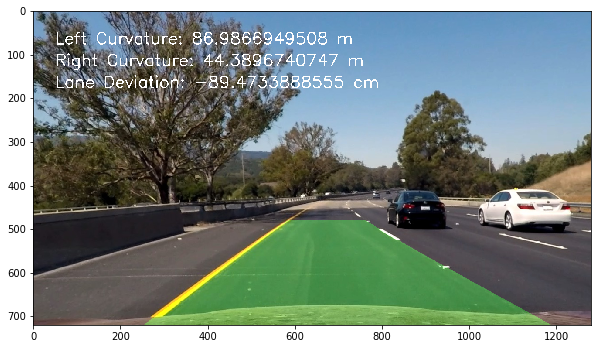

In [13]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fit_cr = np.polyfit(left_points[:,1]*ym_per_pix, left_points[:,0]*xm_per_pix, 2)
right_fit_cr = np.polyfit(right_points[:,1]*ym_per_pix, right_points[:,0]*xm_per_pix, 2)

left_curverad = ((1 + (2*left_fit_cr[0]*719*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*719*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
center_dev = (image.shape[1]/2-(lout[2]+(rout[2]-lout[2])/2))*xm_per_pix*100
print(left_curverad, 'm', right_curverad, 'm')
print((image.shape[1]/2-(lout[2]+(rout[2]-lout[2])/2))*xm_per_pix*100, 'cm')

newwarp = cv2.warpPerspective(output_pol, m_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.putText(result,'Left Curvature: '+str(left_curverad)+' m',(50,75), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
cv2.putText(result,'Right Curvature: '+str(right_curverad)+' m',(50,125), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
cv2.putText(result,'Lane Deviation: '+str(center_dev)+' cm',(50,175), cv2.FONT_HERSHEY_SIMPLEX, 1.25,(255,255,255),2)
plt.imshow(result)